In [164]:
# Standard library imports
import os
from pathlib import Path

# 3rd party imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

in_dir = r"C:\Users\franc\PVcharacterization_files"
list_data_base = []
for path, _, files in os.walk(in_dir):
    list_data_base.extend(Path(path) / Path(file) for file in files 
                                                  if file.endswith(".csv"))

filename = list_data_base[0]

meta_data = pd.read_csv(filename,
                 sep=',',
                 nrows=83,
                 header=None
                 ) # reads the meta data
meta_data = dict(zip(meta_data[0],meta_data[1]))
meta_data = {key.split(':')[0]:val for key,val  in meta_data.items()}

df = pd.read_csv(filename,
                 sep=',',
                 skiprows=165
                 ) # reads the data
#df.plot()

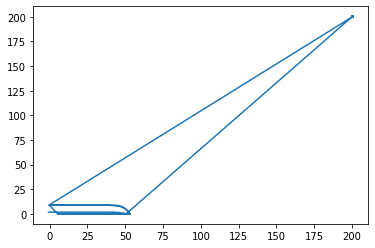

In [75]:
def drop_wrong_values(df)
    x = []
    y = []
    for data_x,data_y in zip(df[' Voltage:    '],df[' Current:']):
        try:
            data_x = float(data_x)
            if data_x != 0:
                x.append(data_x)
                y.append(float(data_y))
        except:
            pass
    return(x,y)
        
plt.plot(x,y)

In [143]:
index_data_header = [0]
for ind,x in enumerate(df[' Voltage:    ']):
    if ('Volt' in x) or  ('Ref Cell' in x):
        index_data_header.append(ind)

index_data_header.append(len(df))
print(index_data_header)
list_df = []

delta=0
for i in range(len(index_data_header)-1):
    if i !=0 :
        delta=1
    list_df.append(df.iloc[df.index.isin(range(index_data_header[i]+delta,
                                               index_data_header[i+1]))])    

[0, 3820, 7641, 12442, 17243, 22044, 26847]


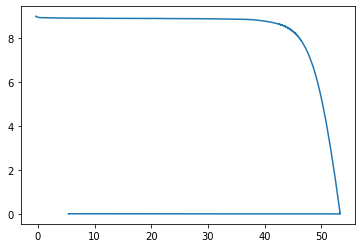

In [163]:
def drop_wrong_values(df):
    x = []
    y = []
    for data_x,data_y in zip(df[' Voltage:    '],df[' Current:']):
        try:
            data_x = float(data_x)
            if data_x != 0.0:
                x.append(data_x)
                y.append(float(data_y))
        except:
            pass
    return(x,y)
color =["r",'g','b']


x,y = drop_wrong_values(list_df[4])
plt.plot(x,y) #,c=color[i])
#plt.xlim(199.5,200.8)

#plt.ylim(0,0.1)

    

In [158]:
x

[-0.350242,
 -0.340652,
 -0.327723,
 -0.299738,
 -0.285347,
 -0.268594,
 -0.251414,
 -0.231949,
 -0.218538,
 -0.207045,
 -0.176647,
 -0.159282,
 -0.144437,
 -0.129341,
 -0.111924,
 -0.097091,
 -0.087403,
 -0.053483,
 -0.037304,
 -0.026046,
 -0.00459,
 0.0123568,
 0.0274529,
 0.0434935,
 0.0732872,
 0.096986,
 0.1128951,
 0.1362844,
 0.1605458,
 0.185667,
 0.2079686,
 0.2448339,
 0.2734567,
 0.3029517,
 0.3343395,
 0.3693228,
 0.3936641,
 0.4251022,
 0.4748673,
 0.5137245,
 0.5446425,
 0.5896796,
 0.6325534,
 0.6727411,
 0.7169451,
 0.7783675,
 0.8336493,
 0.8840051,
 0.9407104,
 1.004761,
 1.064975,
 1.125499,
 1.199142,
 1.272074,
 1.343629,
 1.414393,
 1.495079,
 1.568412,
 1.651386,
 1.749811,
 1.842509,
 1.930699,
 2.030344,
 2.131824,
 2.227205,
 2.334833,
 2.454643,
 2.565438,
 2.681153,
 2.797199,
 2.922811,
 3.041217,
 3.166532,
 3.304981,
 3.437525,
 3.57384,
 3.702754,
 3.848726,
 3.984875,
 4.126254,
 4.282881,
 4.426055,
 4.573647,
 4.725592,
 4.882721,
 5.028188,
 5.177406

In [165]:
meta_data

{'Title': 'HET JNHM72 6x12 M2 0200W',
 'Comment': nan,
 'Op': 'Util',
 'ID': 'JINERGY3272023326035_0200W_T0',
 'Mod Type': 'ModuleType1',
 'Date': '2/15/2021',
 'Time': '14:54:56',
 'Irradiance': '200.333',
 'IrrCorr': '200',
 'Lamp Voltage': '1800',
 'Corrected To': '25',
 'Module Temp': '22.8710',
 'MCCC': '1.0993',
 'Voc': '50.5082',
 'Isc': '1.827',
 'Rseries': '1.95841',
 'Rshunt': '1593.92',
 'Pmax': '72.2867',
 'Vpm': '42.5857',
 'Ipm': '1.69744',
 'Fill Factor': '0.78335',
 'Active Eff': '20.5464',
 'Aperture Eff': '18.1989',
 'Segment Area': '244.32',
 'Segs in Ser': '72',
 'Segs in Par': '1',
 'Panel Area': '19860.1',
 'Vload': '0',
 'Ivld': '0',
 'Pvld': '0',
 'Iload': '0',
 'Vild': '0',
 'Pild': '0',
 'Frequency': '77000',
 'SweepDelay': '20',
 'SweepLength': '230',
 'SweepSlope': '25',
 'SweepDir': '0',
 'MCCC2': '1.1139',
 'MCCC3': '1.155',
 'MCCC4': '1.155',
 'LampI': '200.279',
 'IntV': '6.62821',
 'IntV2': '6.68874',
 'IntV3': '6',
 'IntV4': '6',
 'LoadV': '5.5',
 'Pul